# MLP Network without Keras

(2, 1000) (1000,)


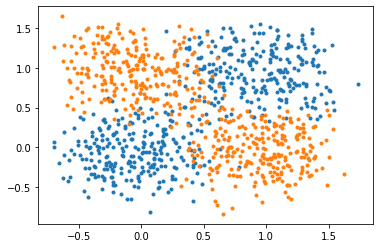

In [63]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle

# load data
D = pickle.load(open("xorData.p", "rb"))
# print(D)

X = D.data - 0.5 # Compensate the inputs offset
y = D.target

print(X.shape, y.shape)
# print(X1[:,0])

plt.figure()
plt.plot(X[0, y == 0], X[1, y == 0], '.')
plt.plot(X[0, y == 1], X[1, y == 1], '.')
# plt.plot(X[0, :], X[1, :], '.')
# plt.plot(y1, y1, '.')
plt.show()


### Network training algorithm a)


In [64]:
def train(
    X=X,
    y=y,
    hidden_units=10,
    adaptation_step=1e-5,  # eta
    moment_term=0.9,  # alpha
    number_of_iterations=500,  # iter
    activation_function=np.tanh,
):

    # Each row for each input
    # Each column for each hidden neuron
    # Start the hidden layer weights with low random values
    Wi = rd.randn(2, hidden_units) * .1
    # print(Wi)

    # Each row for each hidden neuron
    b = np.zeros((hidden_units, 1))
    # print(b)

    # Each row for the output of each hidden neuron
    # Start the output layer weights with low random values
    Wo = rd.randn(hidden_units, 1) * .1
    # print(Wo)

    # Bias for the output layer
    bo = 0

    # Initialize the derivatives
    dzWi = np.zeros(Wi.shape)
    dzb = np.zeros(b.shape)
    dzWo = np.zeros(Wo.shape)
    dzbo = 0

    Error = np.zeros(number_of_iterations)

    for n in range(number_of_iterations):
        # forward pass
        u = np.dot(Wi.T, X) + b
        v = activation_function(u)
        z = np.dot(Wo.T, v) + bo
        yh = activation_function(z)

        # error
        E = y-yh
        Error[n] = np.mean(E**2)

        # gradient
        dz = -2*E*(1-yh**2)
        dbo = np.sum(dz)
        dWo = np.dot(v, dz.T)
        du = (1-v**2)*np.dot(Wo, dz)
        db = np.sum(du, axis=1)
        dWi = np.dot(X, du.T)

        # adapt
        dzWi = moment_term * dzWi + dWi
        dzb = moment_term * dzb + db[:, np.newaxis]
        dzWo = moment_term * dzWo + dWo
        dzbo = moment_term * dzbo + dbo

        Wi = Wi - adaptation_step * dzWi
        b = b - adaptation_step * dzb
        Wo = Wo - adaptation_step * dzWo
        bo = bo - adaptation_step * dzbo

    return Error, yh, Wi, b, Wo, bo


### Train network b) c) d)


Statistics for 1 hidden unit:
Error: 0.20265857931308529
Hidden Units: 1
eta: 0.00067
alpha: 0.9400000000000001
iter: 500
Nº of errors: 324


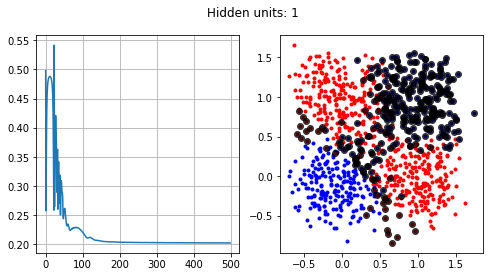

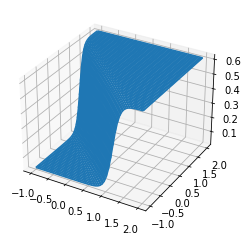

Statistics for 10 hidden unit:
Error: 0.059003088754769326
Hidden Units: 10
eta: 0.00034
alpha: 0.96
iter: 500
Nº of errors: 83


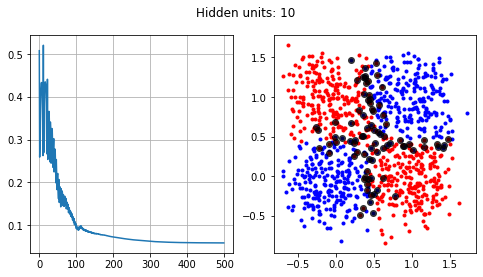

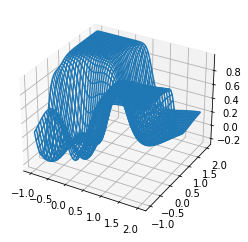

Statistics for 50 hidden unit:
Error: 0.058544164601418876
Hidden Units: 50
eta: 0.00034
alpha: 0.97
iter: 500
Nº of errors: 85


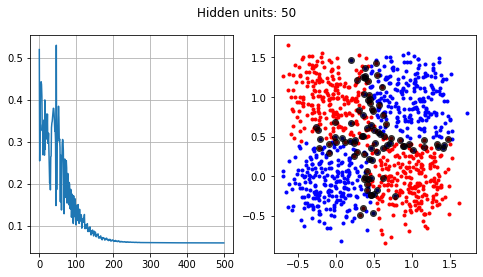

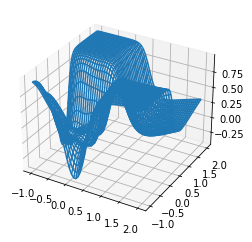

In [65]:
# For 1, 10 and 50 hidden units
for hu in [1, 10, 50]:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(4)
    fig.set_figwidth(8)
    fig.suptitle("Hidden units: " + str(hu))
    best = 1
    best_error = []
    best_yh = []
    best_eta = 0
    best_alpha = 0
    best_Wi = []
    best_b = []
    best_Wo = []
    best_bo = 0
    for eta in np.linspace(1e-5, 1e-3, 10):
        for alpha in np.linspace(0.9, 0.99, 10):
            Error, yh, Wi, b, Wo, bo = train(X, y,
                                             hidden_units=hu,
                                             adaptation_step=eta,  # eta
                                             moment_term=alpha,  # alpha
                                             number_of_iterations=500,  # iter
                                             )

            if Error[len(Error)-1] < best:
                best = Error[len(Error)-1]
                best_error = Error.copy()
                best_yh = yh.copy()
                best_Wi = Wi.copy()
                best_b = b.copy()
                best_Wo = Wo.copy()
                best_bo = bo
                best_eta = eta
                best_alpha = alpha
    axes[0].plot(best_error)
    axes[0].grid(True)
    print('Statistics for', hu, 'hidden unit:')

    print('Error: ' + str(best) +
          '\nHidden Units: ' + str(hu) +
          '\neta: ' + str(best_eta) +
          '\nalpha: ' + str(best_alpha) +
          '\niter: ' + str(len(best_error)))

    # Training set errors
    ye = (best_yh.squeeze() >= 0.5)
    axes[1].plot(X[0, y == 0], X[1, y == 0], '.b')
    axes[1].plot(X[0, y == 1], X[1, y == 1], '.r')
    axes[1].plot(X[0, y != ye], X[1, y != ye], 'ok', alpha=.7)
    print('Nº of errors:', np.sum(y != ye))

    # Wireframe

    gX, gY = np.meshgrid(np.linspace(-1, 2, 50), np.linspace(-1, 2, 50))
    X2 = np.vstack((gX.ravel(), gY.ravel()))
    u = np.dot(best_Wi.T, X2)+best_b
    v = np.tanh(u)
    z = np.dot(best_Wo.T, v)
    yh = np.tanh(z+best_bo)
    Yh = np.reshape(yh, (50, 50))

    plt.figure()
    ax = plt.axes(projection='3d')
    # ax.contour3D(gX,gY,Yh,50,cmap='binary')
    ax.plot_wireframe(gX, gY, Yh)
    plt.show()


We can see that when we train with 1 hidden unit, the network is not able to learn the function because with only 1 hidden unit, there's no way differentiate the data with an intersection

With 10 or 50 units we see not much difference, indicating that adding more hidden units is not usefull. Maybe a better result could be achieved increasing the number of hidden layers instead of the number of hidden units

We can see that the best alpha is close to 1 because at the end of the iterations, the network was able to reach that error value relatively fast compared to other alpha values


# MLP Network with Keras

### a)

In [66]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from skimage import color
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()

# Transform data into array from 1-col matrix
ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

# Randomize train data
idx = rd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

# Sort test data
idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]

# Convert to grayscale
XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])

# Convert to vector
XtrainGV = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestGV = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

# Categorical
ytrainC = keras.utils.to_categorical(ytrain)
ytestC = keras.utils.to_categorical(ytest)

X1_train, X1_val, y1_train, y1_val = train_test_split(
    XtrainGV, ytrainC, test_size=0.1)

# Pre-processing

# ss = StandardScaler().fit(XtrainGV)
# XtrainGVp = ss.transform(XtrainGV)
# XtestGVp = ss.transform(XtestGV)
# X1_trainP = ss.transform(X1_train)
# X1_valP = ss.transform(X1_val)

n_components = 250
pca = PCA(n_components=n_components).fit(XtrainGV)
XtrainGVp = pca.transform(XtrainGV)
XtestGVp = pca.transform(XtestGV)
X1_trainP = pca.transform(X1_train)
X1_valP = pca.transform(X1_val)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [67]:
X1 = XtrainGV
y1 = ytrain
y1C = ytrainC

X1p = XtrainGVp
X1s = X1_train
X1sp = X1_trainP
X1sVal = X1_val
X1sValP = X1_valP
y1s = y1_train
y1sVal = y1_val

X2 = XtestGV
X2p = XtestGVp
y2 = ytest
y2C = ytestC


In [68]:
nn = keras.Sequential()
nn.add(keras.layers.Flatten(input_shape=(32*32,)))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(10, activation="softmax"))

nn.compile(optimizer="nadam",
           loss=keras.losses.mean_squared_error,
           metrics=["accuracy"],
           )

print(nn.summary())


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 1024)              0         
                                                                 
 dense_116 (Dense)           (None, 100)               102500    
                                                                 
 dense_117 (Dense)           (None, 100)               10100     
                                                                 
 dense_118 (Dense)           (None, 100)               10100     
                                                                 
 dense_119 (Dense)           (None, 100)               10100     
                                                                 
 dense_120 (Dense)           (None, 100)               10100     
                                                                 
 dense_121 (Dense)           (None, 100)             

Epoch 1/50
49/49 [==============================] - 2s 17ms/step - loss: 0.0897 - accuracy: 0.1192 - val_loss: 0.0881 - val_accuracy: 0.1573
Epoch 2/50
49/49 [==============================] - 1s 14ms/step - loss: 0.0876 - accuracy: 0.1735 - val_loss: 0.0866 - val_accuracy: 0.1962
Epoch 3/50
49/49 [==============================] - 1s 14ms/step - loss: 0.0867 - accuracy: 0.2006 - val_loss: 0.0857 - val_accuracy: 0.2359
Epoch 4/50
49/49 [==============================] - 1s 14ms/step - loss: 0.0849 - accuracy: 0.2437 - val_loss: 0.0850 - val_accuracy: 0.2298
Epoch 5/50
49/49 [==============================] - 1s 14ms/step - loss: 0.0837 - accuracy: 0.2657 - val_loss: 0.0818 - val_accuracy: 0.2923
Epoch 6/50
49/49 [==============================] - 1s 15ms/step - loss: 0.0833 - accuracy: 0.2724 - val_loss: 0.0810 - val_accuracy: 0.3138
Epoch 7/50
49/49 [==============================] - 1s 14ms/step - loss: 0.0812 - accuracy: 0.3044 - val_loss: 0.0807 - val_accuracy: 0.3103
Epoch 8/50
49

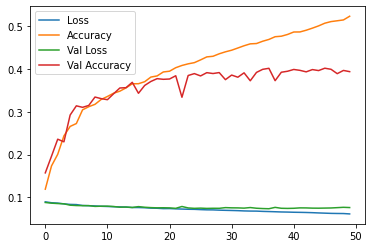

In [69]:
train = nn.fit(X1, y1C,
               epochs=50,
               batch_size=1024,
               validation_data=(X2, y2C),
               use_multiprocessing=True,
               )

h = train.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Accuracy')
plt.legend()
plt.show()


In [70]:
y2e = nn.predict(X2)
y2p = np.argmax(y2e, axis=1)

print('Nº of errors:', np.sum(y2 != y2p))


Nº of errors: 6064


Despite the accuracy increasing, the val_accuracy doesn't improve, indicating that the network stopped learning for new inputs and is now memorizing the training data
We confirm that seeing that the val_loss started increasing a little bit at 50 epochs +-


### b)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 250)               0         
                                                                 
 dense_127 (Dense)           (None, 512)               128512    
                                                                 
 dense_128 (Dense)           (None, 512)               262656    
                                                                 
 dense_129 (Dense)           (None, 10)                5130      
                                                                 
Total params: 396,298
Trainable params: 396,298
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
44/44 [==============================] - 2s 27ms/step - loss: 1.9649 - accuracy: 0.3057 - val_loss: 1.8388 - val_accuracy: 0.3562
Epoch 2/40
44/44 [===============

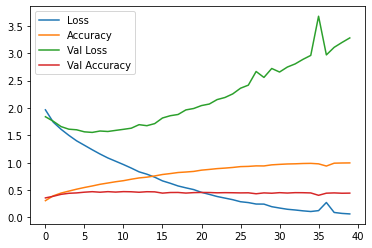

In [71]:
nn = keras.Sequential()
nn.add(keras.layers.Flatten(input_shape=(n_components,)))

nn.add(keras.layers.Dense(512, activation="relu"))
nn.add(keras.layers.Dense(512, activation="relu"))
nn.add(keras.layers.Dense(10, activation="softmax"))

nn.compile(optimizer="nadam",
           loss='categorical_crossentropy',
           metrics=["accuracy"],
           )

print(nn.summary())

train = nn.fit(X1sp, y1s,
               epochs=40,
               batch_size=1024,
               validation_data=(X1sValP, y1sVal),
               use_multiprocessing=True,
               )

h = train.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Accuracy')
plt.legend()
plt.show()


We will measure the model's performance based on the Val Accuracy, since that's the curve shaped by new values (the validation set). As we inspect the figure above, we instantly note that Val Loss increasing over time, which is a sign of overfitting. Also, the Val Accuracy stagnates below 0.5. To overcome this problem, we should add Dropout layers to mitigate the effect of overfitting.

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 250)               0         
                                                                 
 dense_133 (Dense)           (None, 512)               128512    
                                                                 
 dropout_66 (Dropout)        (None, 512)               0         
                                                                 
 dense_134 (Dense)           (None, 512)               262656    
                                                                 
 dropout_67 (Dropout)        (None, 512)               0         
                                                                 
 dense_135 (Dense)           (None, 10)                5130      
                                                                 
Total params: 396,298
Trainable params: 396,298
Non-t

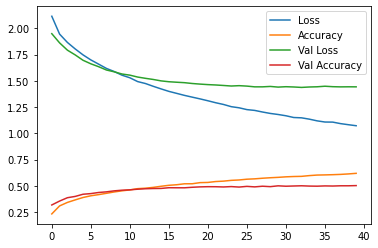

In [74]:
nn2 = keras.Sequential()
nn2.add(keras.layers.Flatten(input_shape=(n_components,)))

nn2.add(keras.layers.Dense(512, activation="relu"))
nn2.add(keras.layers.Dropout(0.5))
nn2.add(keras.layers.Dense(512, activation="relu"))
nn2.add(keras.layers.Dropout(0.5))
nn2.add(keras.layers.Dense(10, activation="softmax"))

nn2.compile(optimizer="nadam",
           loss='categorical_crossentropy',
           metrics=["accuracy"],
           )

print(nn2.summary())

train = nn2.fit(X1sp, y1s,
               epochs=40,
               batch_size=1024,
               validation_data=(X1sValP, y1sVal),
               use_multiprocessing=True,
               )

h2 = train.history
plt.plot(h2["loss"], label='Loss')
plt.plot(h2["accuracy"], label='Accuracy')
plt.plot(h2["val_loss"], label='Val Loss')
plt.plot(h2["val_accuracy"], label='Val Accuracy')
plt.legend()
plt.show()


We now see no sign of overfitting. Also, the Val Accuracy stagnates a little bit above 0.5, which is what we were expecting. Using MLP models, it's difficult to get much better results.

In [73]:
y2e = nn.predict(X2p)
y2p = np.argmax(y2e, axis=1)

print('Nº of errors:', np.sum(y2 != y2p))


Nº of errors: 5656
